In [1]:
import anndata as ad
import os
from SpatialQuery.spatial_query import spatial_query
from SpatialQuery.spatial_query_multiple_fov import spatial_query_multi
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

In [10]:
from os.path import join

In [11]:
data_path = "./data/HBM987_KWLK_254/"

# adata_expr = ad.read_h5ad(os.path.join(data_path, 'expr.h5ad'))
adata = ad.read_h5ad(join("data", "HBM987_KWLK_254", "secondary_analysis.h5ad"))
fig_size = (8, 4)

In [3]:
adata

AnnData object with n_obs × n_vars = 4058 × 26265
    obs: 'n_genes', 'n_counts', 'leiden', 'umap_density', 'predicted.ASCT.celltype', 'predicted.ASCT.celltype.score'
    var: 'hugo_symbol', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'annotation_metadata', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'umap_density_params'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'X_umap_proj'
    varm: 'PCs'
    layers: 'spliced', 'spliced_unspliced_sum', 'unscaled', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
spatial_key = 'X_spatial'
label_key = 'predicted.ASCT.celltype'

In [5]:
# Test building kd tree
tt = spatial_query(adata=adata, dataset = 'test', spatial_key=spatial_key, label_key=label_key, leaf_size=10)

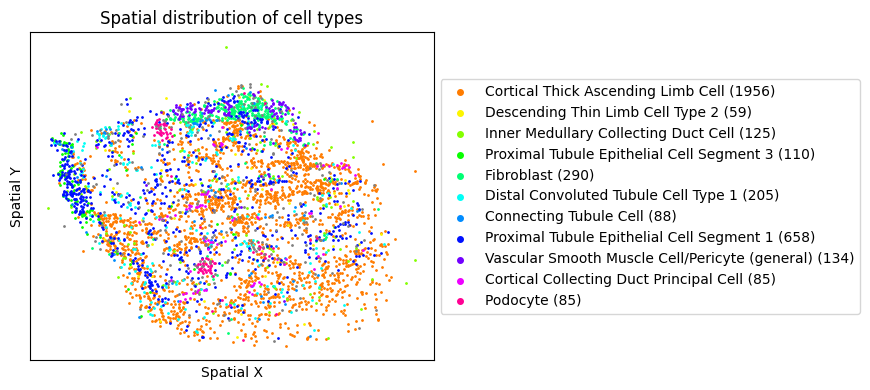

In [6]:
# tt.plot_fov(fig_size=fig_size)
tt.plot_fov(fig_size=fig_size)

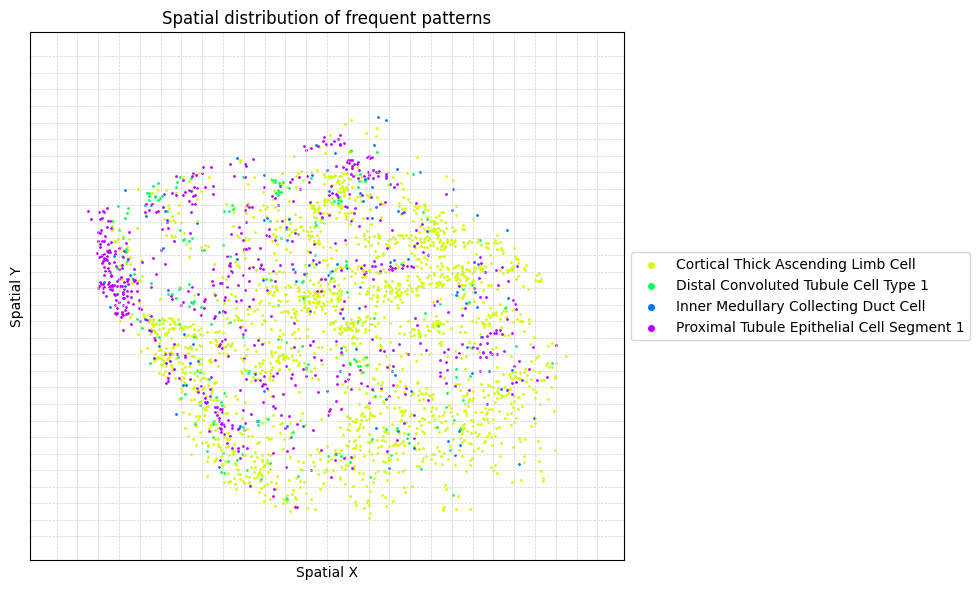

In [7]:
# Test frequent patterns of fov
max_dist = 150
min_size = 4
min_count = 10
min_support = 0.5
dis_duplicates=True # if distinguish duplicates of cell types in neighborhood


fp_tree =tt.find_patterns_grid(max_dist=max_dist,
                               min_size=min_size,
                               min_count=min_count,
                               min_support=min_support, 
                               dis_duplicates=dis_duplicates,
                               if_display=True,
                               fig_size = (9, 6),
                               return_cellID=True,
                              ) 

In [8]:
fp_tree

,support,itemsets,cell_id
0,0.528986,"[Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell]","{0, 2, 9, 11, 18, 21, 22, 24, 28, 35, 36, 37, 38, 43, 45, 48, 51, 52, 53, 54, 55, 57, 58, 60, 61, 62, 64, 67, 76, 77, 81, 83, 84, 88, 89, 92, 96, 97, 99, 100, 109, 111, 114, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 134, 136, 138, 140, 145, 146, 148, 156, 157, 159, 160, 162, 163, 170, 176, 177, 180, 182, 183, 185, 189, 191, 193, 194, 196, 202, 205, 206, 211, 212, 217, 222, 223, 228, 229, 231, 234, 239, 241, 242, 246, 247, 250, 251, ...}"
1,0.514493,"[Proximal Tubule Epithelial Cell Segment 1, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Proximal Tubule Epithelial Cell Segment 1, Proximal Tubule Epithelial Cell Segment 1, Cortical Thick Ascending Limb Cell]","{0, 2, 4, 5, 6, 9, 11, 20, 21, 22, 23, 24, 26, 27, 28, 36, 37, 38, 45, 46, 47, 48, 49, 51, 52, 54, 55, 57, 58, 59, 60, 61, 64, 65, 66, 71, 73, 76, 77, 80, 82, 83, 84, 85, 87, 88, 89, 91, 92, 93, 94, 96, 97, 98, 99, 101, 104, 105, 106, 111, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 133, 134, 135, 138, 140, 144, 146, 148, 150, 157, 159, 160, 161, 162, 163, 164, 165, 170, 176, 177, 180, 181, 183, ...}"
2,0.509662,"[Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Distal Convoluted Tubule Cell Type 1, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell]","{0, 2, 5, 6, 9, 21, 22, 24, 28, 32, 35, 36, 37, 38, 44, 48, 51, 52, 53, 54, 55, 57, 58, 60, 61, 62, 64, 67, 73, 76, 77, 82, 83, 89, 92, 95, 96, 97, 99, 109, 111, 114, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 136, 138, 142, 144, 146, 148, 158, 159, 160, 162, 163, 169, 170, 171, 176, 177, 180, 182, 183, 185, 191, 193, 194, 196, 202, 206, 207, 212, 217, 222, 223, 226, 228, 229, 234, 237, 239, 241, 242, 246, 247, ...}"
3,0.509662,"[Proximal Tubule Epithelial Cell Segment 1, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Proximal Tubule Epithelial Cell Segment 1, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell]","{0, 2, 6, 9, 11, 21, 22, 23, 24, 27, 28, 35, 36, 37, 38, 43, 45, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 60, 61, 62, 64, 65, 66, 67, 71, 73, 76, 77, 80, 81, 82, 83, 84, 85, 87, 88, 89, 92, 93, 96, 97, 98, 99, 101, 104, 105, 106, 110, 111, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 138, 140, 144, 146, 148, 150, 157, 159, 160, 161, 162, 163, 164, 165, 170, 176, 177, 180, 181, 183, ...}"
4,0.507246,"[Cortical Thick Ascending Limb Cell, Inner Medullary Collecting Duct Cell, Cortical Thick Ascending Limb Cell]","{0, 2, 5, 6, 9, 11, 21, 22, 24, 28, 35, 36, 37, 38, 43, 45, 48, 51, 52, 53, 54, 55, 57, 58, 60, 62, 64, 67, 73, 74, 75, 76, 77, 82, 83, 84, 88, 89, 92, 96, 97, 99, 100, 103, 109, 111, 114, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 134, 136, 138, 140, 144, 145, 146, 148, 156, 160, 162, 163, 169, 170, 176, 177, 180, 182, 183, 191, 193, 194, 196, 202, 205, 206, 211, 212, 217, 222, 223, 224, 228, 229, 230, 234, 235, 242, 246, ...}"
5,0.507246,"[Proximal Tubule Epithelial Cell Segment 1, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical Thick Ascending Limb Cell, Cortical

In [9]:
from vitessce import (
    VitessceConfig,
    AnnDataWrapper,
    ViewType as vt,
    CoordinationType as ct,
)

In [32]:
zarr_path = join("data", "HBM987_KWLK_254", "secondary_analysis.h5ad.zarr")
adata.write_zarr(zarr_path)

In [55]:
vc = VitessceConfig(schema_version="1.0.16", name="Spatial-Query")
dataset = vc.add_dataset("Query results").add_object(AnnDataWrapper(
    adata_path=zarr_path,
    obs_feature_matrix_path="X",
    obs_set_paths=["obs/predicted.ASCT.celltype"],
    obs_set_names=["Cell Type"],
    obs_spots_path="obsm/X_spatial",
    coordination_values={
        "obsType": "spot",
    }
))

spatial_view = vc.add_view("spatialBeta", dataset=dataset)
lc_view = vc.add_view("layerControllerBeta", dataset=dataset)
sets_view = vc.add_view("obsSets", dataset=dataset)
features_view = vc.add_view("featureList", dataset=dataset)

vc.link_views([spatial_view, lc_view, sets_view, features_view], ["obsType"], ["spot"])

vc.set_coordination_value("spatialSpotRadius", "init_A_obsSpots_0", 15)

vc.layout((spatial_view | lc_view) / (sets_view | features_view));

In [56]:
vc.widget(height=900)

/Users/mkeller/software/miniconda3/envs/spatial-query/lib/python3.11/site-packages/traitlets/traitlets.py:842: DeprecationWarning: Deprecated in traitlets 4.1, use the instance .metadata dictionary directly, like x.metadata[key] or x.metadata.get(key, default)
  warn("Deprecated in traitlets 4.1, " + msg, DeprecationWarning, stacklevel=2)
/Users/mkeller/software/miniconda3/envs/spatial-query/lib/python3.11/site-packages/traitlets/traitlets.py:842: DeprecationWarning: Deprecated in traitlets 4.1, use the instance .metadata dictionary directly, like x.metadata[key] or x.metadata.get(key, default)
  warn("Deprecated in traitlets 4.1, " + msg, DeprecationWarning, stacklevel=2)


VitessceWidget(config={'version': '1.0.16', 'name': 'Spatial-Query', 'description': '', 'datasets': [{'uid': '…